In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import math
import os

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np


torch.manual_seed(5)    # fix random seed for reproducibility

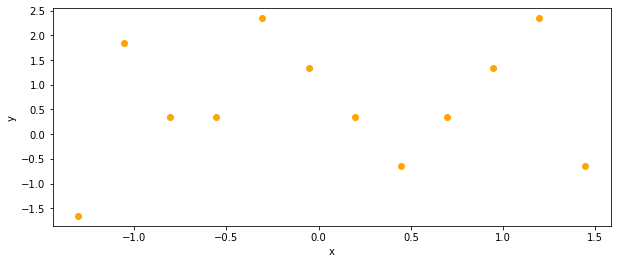

In [2]:
x = torch.Tensor((np.array([-5.5,-4.5,-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5,5.5])/4+0.07).reshape(-1,1))  # same data as paper by Maennel
y = torch.Tensor(.345 + np.array([-2, 1.5, 0, 0, 2, 1, 0, -1, 0, 1, 2, -1]).reshape(-1,1)) 

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

# view data
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
import torch.nn as nn


class Net(torch.nn.Module):
    """
    1 hidden layer Relu network
    """
    def __init__(self, n_feature, n_hidden, n_output, init_scale=1, bias=True):
        """
        n_feature: dimension of input
        n_hidden: number of hidden neurons
        n_output: dimension of output
        init_scale: all the weights are initialized ~ N(0, init_scale^2/m) where m is the input dimension of this layer
        bias: if True, use bias parameters in all layers. Use no bias otherwise
        """
        super(Net, self).__init__()
        self.init_scale = init_scale
        
        # The initialization follows the one from Blanc et al.
        self.hidden = torch.nn.Linear(n_feature, n_hidden, bias=bias)   # hidden layer with rescaled init
        self.hidden.weight.data = torch.rand_like(self.hidden.weight)
        self.hidden.weight.data = 2.5 * (-1 + 2 * torch.round(self.hidden.weight.data)) * init_scale
        self.hidden.bias.data = torch.randn_like(self.hidden.bias)
        self.hidden.bias.data = self.hidden.bias.data * 2.5 * init_scale
        
        self.predict = torch.nn.Linear(n_hidden, n_output, bias=False)   # output layer with rescaled init
        self.predict.weight.data = torch.randn_like(self.predict.weight)
        self.predict.weight.data = self.predict.weight.data * 4.0 * init_scale

    def forward(self, z):
        z = F.relu(self.hidden(z))      # activation function for hidden layer
        z = self.predict(z)             # linear output
        return z

In [ ]:
for seed in [0, 1, 2, 3, 4]:
    np.random.seed(seed)
    torch.manual_seed(seed)
    init_scale = 1.0
    net = Net(n_feature=1, n_hidden=100, n_output=1, init_scale=init_scale)     # define the network

    lr_decay = True
    sam_grad_normalization = True
    lr_max = 0.00005  
    rho = 0.0  # use 0.3 for SAM
    optimizer = torch.optim.SGD(net.parameters(), lr=lr_max)#, momentum=0.9)
    loss_func = torch.nn.MSELoss(reduction='sum')  # this is for regression mean squared loss

    n_samples = x.shape[0]
    iter_max = 1000000
    n_batch = n_samples # batch size for SGD

    loss = torch.Tensor(np.array(np.inf))
    # train the network
    n_iterations = 0 # number of descent steps
    while n_iterations<iter_max+1 and loss > 10**-5:
        n_iterations += 1
        # optimizer.param_groups[0]['lr'] = lr_max * (0.5 + 0.5*math.cos(math.pi * n_iterations / iter_max))
        indices = np.random.choice(n_samples, size=n_batch, replace=False)
        batch_x, batch_y = x[indices], y[indices]

        prediction = net(batch_x)     # input x and predict based on x
        loss = 0.5*loss_func(prediction, batch_y)     # must be (1. nn output, 2. target)

        if n_iterations % 2000 == 1:
            print(n_iterations, loss)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients

        if rho > 0.0:
            orig_weights = [param.clone() for param in list(net.parameters())]
            optimizer.param_groups[0]['lr'] = -rho

            if sam_grad_normalization:
                with torch.no_grad():
                    grad_norm = 0
                    for param_curr in net.parameters():
                        grad_norm += (param_curr.grad**2).sum() 
                    grad_norm = grad_norm**0.5
                    for param_curr in net.parameters():
                        param_curr.grad /= grad_norm
            # print(net.hidden.weight.grad[:5])
            optimizer.step()        # descent step
            
            if lr_decay:
                # optimizer.param_groups[0]['lr'] = lr_max * (0.5 + 0.5*math.cos(math.pi * n_iterations / iter_max))
                optimizer.param_groups[0]['lr'] = lr_max * (1 - n_iterations / iter_max)
            else:
                optimizer.param_groups[0]['lr'] = lr_max

            prediction = net(batch_x)     # input x and predict based on x
            loss = 0.5*loss_func(prediction, batch_y)     # must be (1. nn output, 2. target)
        
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients

            for param_curr, param_orig, in zip(list(net.parameters()), orig_weights):
                param_curr.data = param_orig.data
        # print(net.hidden.weight.grad[:5])
        optimizer.step()        # descent step

    print(n_iterations, loss)

    torch.save(net, 'models_simple/model-lr={}-rho={}-seed={}.pt'.format(lr_max, rho, seed))

    # plot and show learning process
    plt.figure()
    # plt.title('Regression')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.scatter(x.data.numpy(), y.data.numpy(), color="orange")
    plt.ylim(1.3*y.data.numpy().min(), 1.2*y.data.numpy().max())
    grid_step = 0.01
    x_grid = np.arange(x.data.numpy().min() - 5*grid_step, x.data.numpy().max() + 5*grid_step, grid_step)
    y_preds = net(torch.Tensor(x_grid.reshape(-1, 1))).detach()
    plt.plot(x_grid, y_preds, 'g-', lw=3)
    plt.show()
    print(n_iterations)